In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
plt.style.use('ggplot')
from libs.utils import montage
from libs import gif
%matplotlib inline

In [2]:
from libs.datasets import MNIST

In [3]:
ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
ds

In [5]:
ds.X.shape

(70000, 784)

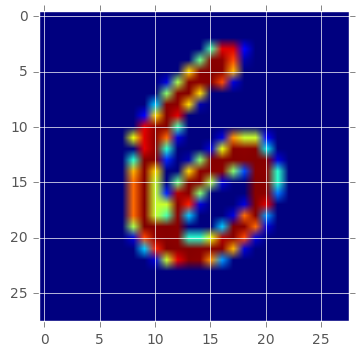

In [6]:
plt.imshow(ds.X[0].reshape((28,28)))

In [7]:
imgs = ds.X[:1000].reshape((-1,28, 28))

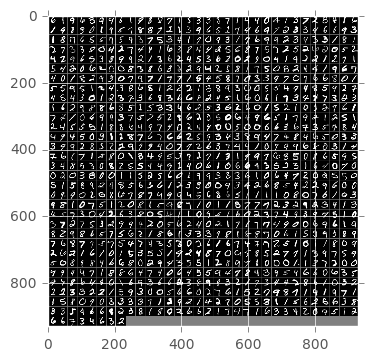

In [8]:
plt.imshow(montage(imgs), cmap='gray')

In [9]:
mean_imgs = np.mean(ds.X, axis=0)

In [10]:
plt.figure()

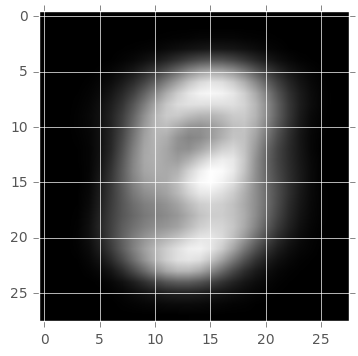

In [11]:
plt.imshow(mean_imgs.reshape((28, 28)), cmap='gray')

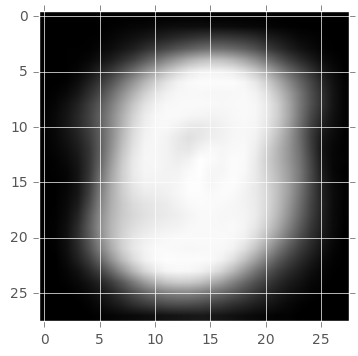

In [12]:
std_imgs = np.std(ds.X, axis=0)
plt.imshow(std_imgs.reshape((28, 28)), cmap='gray')

In [13]:
#we will try to encode what could possibly change in the image, we will build fully connected layer that gets progressively 
# smaller and in NN terms every input pixel will become it's own neuron
dimensions = [512, 256, 128, 64]

In [14]:
n_features = ds.X.shape[1]

In [15]:
import tensorflow as tf

In [16]:
X = tf.placeholder(tf.float32, [None, n_features])

In [17]:
current_input = X
n_input = n_features
Ws = []

In [ ]:
#Encoder
for layer_i, n_output in enumerate(dimensions):
    #we will use variable dimension to shape our input
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        #create a weight matrix that will increasingly reduce
        #down the amount of information in the input by performing
        #a matrix multiplication
        W = tf.get_variable(
            name = 'W',
            shape = [n_input, n_output],
            initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02))
        #Now we'll multiply our input by our newly created W matrix and add the bias
        h = tf.matmul(current_input, W)
        
        #and then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        
        #Finally we'll store the weight matrix so that we can buld the decoder
        Ws.append(W)
        
        #we will also replace n_input with the current n_output, so that on the 
        # next iteration, our new number inputs will be correct 
        n_input = n_output

In [18]:
Ws = Ws[::-1]

In [19]:
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]

In [20]:
print(dimensions)

[128, 256, 512, 784]


In [ ]:
#Decoder
for layer_i, n_output in enumerate(dimensions):
    # We'll use a variable scope again to help encapsulate our variables
    # This will prefix all the variables made in this scope
    # with the name we give it
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        #Now we'll grab the weight matrix that we created and transpose it
        # so a 3072 X 784 matrix would become 784 X 3072
        # or a 256 X 64 matrix would become 64 X 256 
        W = tf.transpose(Ws[layer_i])
        
        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(current_input, W)
        
        # Use relu on this output
        current_input = tf.nn.relu(h)
        
        #we will also replace n_input with the current n_output, so that on the 
        # next iteration, our new number inputs will be correct 
        n_input = n_output

In [ ]:
Y = current_input

In [ ]:
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)

In [ ]:
print(cost.get_shape())

In [ ]:
cost = tf.reduce_mean(cost)

In [ ]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [ ]:
batch_size = 100
n_epochs = 10
examples = ds.X[:100]
imgs = []

In [ ]:
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: examples - mean_imgs})
    recon = sess.run(Y, feed_dict={X: examples - mean_imgs})
    recon = np.clip((recon + mean_imgs).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.int8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_imgs}))
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [21]:
#Convolutional autoencoder
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

In [22]:
X = tf.placeholder(tf.float32, [None, n_features])

In [23]:
#In order to to use convolutional we have to convert into a 4d tensor
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

In [24]:
#In the fully connected network every pixel is multiplied with its own weights and all weights are unique
#In convolutional network we use the extra dimension to allow same set of filter to be applied everywhere in the image.
#This is known as weight sharing, Also after convolution we are still keeping the spatial dimension of the input as we still 
# have dimension of heith and width unlike fuly connected network which shuffles or effectively take into account 
# of information from everywhere not caring about where everythng is and that can be useful or not depending on what are we 
# trying to achieve like for example after we do some convolutional we might want to encode translation invariannce and fully connected network will help
# Hence we will see that in CovNet architecture we often use fully connected network at the end.


n_filters = [16, 16, 16]
filter_size = [4, 4, 4]
current_input = X_tensor
n_input = 1 #No of channels
Ws = []
shapes = []
for layer_i, n_output in enumerate(n_filters):
    #Just like in the last session
    # we will use a variable scope to help encapsulate our variables
    #This will simply prefix all the variables model in this scope
    #with the name we give it
    with tf.variable_scope("encoder/layer/{}".format(layer_i), reuse=None):
        #we will keep track of the shapes of each layer
        #as we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())

        
        #create a weight matrix which will increasingly reduce
        #down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name = 'W',
            shape =[
                 filter_size[layer_i],
                 filter_size[layer_i],
                 n_input,
                 n_output],
                 initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        #Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides =[1,2,2,1], padding='SAME')
        
        # and then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        
        #Finally we'll store the weight matrix so we can build the decoder
        Ws.append(W)
        
        #we'll also replace n_input with the current n_output, so that on the 
        #next iteration, our new number inputs will be correct
        n_input = n_output

In [25]:
Ws.reverse()
shapes.reverse()
n_filters.reverse()

In [26]:
n_filters = n_filters[1:] + [1]

In [27]:
print(n_filters, filter_size, shapes)

([16, 16, 1], [4, 4, 4], [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]])


In [28]:
for layer_i, shape in enumerate(shapes):
    # Loop through convolution to get our input image back
    # we will use a variable scope to help encapsulate our variables
    
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        #we will keep track of the shapes of each layer
        #as we'll need these for the decoder    
        #create a weight matrix which will increasingly reduce
        #down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]
        #Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.pack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides =[1,2,2,1], padding='SAME')
        
        # and then use a relu activation function on its output
        current_input = tf.nn.relu(h)

In [34]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
batch_size=100
n_epochs = 10
examples = ds.X[:100]
imgs = []

(0, 0.032946758)
(1, 0.032069229)
(2, 0.032695867)
(3, 0.033407409)
(4, 0.033792406)
(5, 0.033826925)
(6, 0.034366738)
(7, 0.034177221)
(8, 0.03442283)
(9, 0.033626746)


IOError: Error saving animation to file (cause: [Errno 32] Broken pipe) Stdout:  StdError: . It may help to re-run with --verbose-debug.

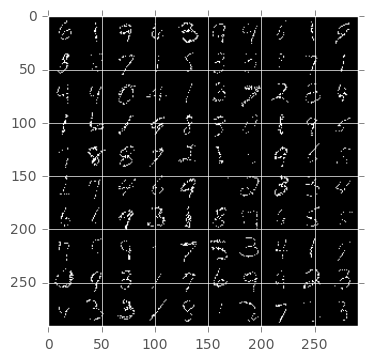

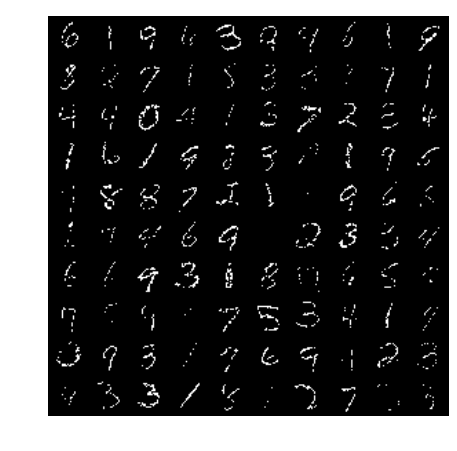

In [36]:
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: examples - mean_imgs})
    recon = sess.run(Y, feed_dict={X: examples - mean_imgs})
    recon = np.clip((recon + mean_imgs).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.int8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_imgs}))
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')